# Analysis of JARVIS-DFT Pre-trained Model: Bandgap Prediction Loss Landscapes

## Overview

This notebook provides an analysis of loss landscapes for a pre-trained JARVIS-DFT model specifically designed for bandgap prediction. The analysis employs Hessian-based eigenvector decomposition to understand the geometric properties of the optimization landscape and identify patterns in model behavior across different material samples.

### Research Objectives
- Characterize the loss landscape geometry of a pre-trained bandgap prediction model
- Identify out-of-distribution (OOD) samples through loss landscape analysis
- Understand the relationship between loss landscape properties and model predictions

### Experimental Setup
- **Model**: Pre-trained JARVIS-DFT model for bandgap prediction
- **Dataset**: First 3,000 samples from JARVIS-DFT bandgap dataset
- **Target Property**: Bandgap (optb88vdw_bandgap)
- **Analysis Method**: Hessian eigenvector-based loss landscape computation
- **Eigenvalue Computation**: Based on 100 samples with lowest prediction error (50 with bandgap = 0, 50 with bandgap ≠ 0)

### Analysis Framework
1. **Model Performance Assessment**: Evaluation of prediction accuracy and error patterns
2. **Hessian Eigenvalue Analysis**: Characterization of loss curvature properties
3. **Loss Landscape Visualization**: Geometric analysis of optimization surfaces
4. **Dimensionality Reduction**: UMAP-based analysis of landscape similarities
5. **Clustering Analysis**: Identification of distinct landscape patterns
6. **Tilt Angle Analysis**: Detection and characterization of out-of-distribution samples


## 1. Environment Setup and Library Imports

### Required Dependencies
Setting up the computational environment with essential libraries for:
- Data manipulation and analysis (pandas, numpy)
- Visualization (matplotlib)
- Machine learning and clustering (scikit-learn, UMAP)
- Custom utilities for loss landscape processing and visualization
- Tilt angle computation for out-of-distribution detection


In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
import umap
from util.general import flatten_and_vstack, create_selectors
from util.landscape_processing import restore_to_square_shape
from util.plot import plot_loss_landscape, visualize_image_clusters, plot_categorical_data, plot_numerical_data, plot_umap_parameter_grid, plot_umap_scatter, plot_twin_umap_scatter
import os
from src.tilt_angle import compute_best_tilt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed to 'ensure_all_finite'")

## 2. Data Loading and Preprocessing

### Loss Landscape Data Import
Loading pre-computed loss landscape data from the designated folder. This data contains loss landscapes computed for the first 3,000 JARVIS-DFT bandgap samples using Hessian eigenvector analysis based on the 100 samples with lowest prediction error. (The folder was named incorrectly.)

In [2]:
folders = [r'computed_loss_landscapes\first_3000_ON_EIGVEC_JVDFT_bandgap_custom_lowest_250_error_of_3000']

In [3]:
loss_function_dicts = []
for folder in folders:
    with open(os.path.join(folder,'processed_loss_function_dict.pkl'), 'rb') as file:
        loss_function_dicts.append(pickle.load(file))


# Merge all dictionaries from loss_function_dicts into a single dictionary
merged_loss_function_dict = {}
for d in loss_function_dicts:
    for key, value in d.items():
        if key not in merged_loss_function_dict:
            merged_loss_function_dict[key] = value
        else:
            # If key exists, update/append values
            merged_loss_function_dict[key].update(value)

# Update the loss_function_dict to use merged version
loss_function_dict = merged_loss_function_dict

with open(os.path.join(folders[0],'feat_sample_df.pkl'), 'rb') as file:
    feat_sample_df = pickle.load(file)

with open(os.path.join(folders[0],'feat_sample_composition_df.pkl'), 'rb') as file:
    feat_sample_composition_df = pickle.load(file)

with open(os.path.join(folders[0],'feat_sample_structure_df.pkl'), 'rb') as file:
    feat_sample_structure_df = pickle.load(file)

sample_dict = {
    'feat_sample_df': feat_sample_df,
    'feat_sample_composition_df': feat_sample_composition_df,
    'feat_sample_structure_df': feat_sample_structure_df}

combined_dict = {**sample_dict, **loss_function_dict}

In [19]:
combined_dict['feat_sample_df'] = pd.read_pickle(r'data\JARVIS-DFT\subset\bandgap_first_3000_data_df.pkl')
all_data_jids = combined_dict['feat_sample_df']['jid'].values

## 3. Model Performance Assessment

### Prediction Analysis
Evaluating the pre-trained JARVIS-DFT model's performance on bandgap prediction through multiple visualization approaches:

1. **Parity Plot**: Actual vs predicted bandgap values to assess overall model accuracy
2. **Error Analysis**: Relationship between actual values and prediction errors
3. **Prediction Reliability**: Correlation between predicted values and absolute errors
4. **Error Distribution**: Statistical distribution of prediction errors across the dataset


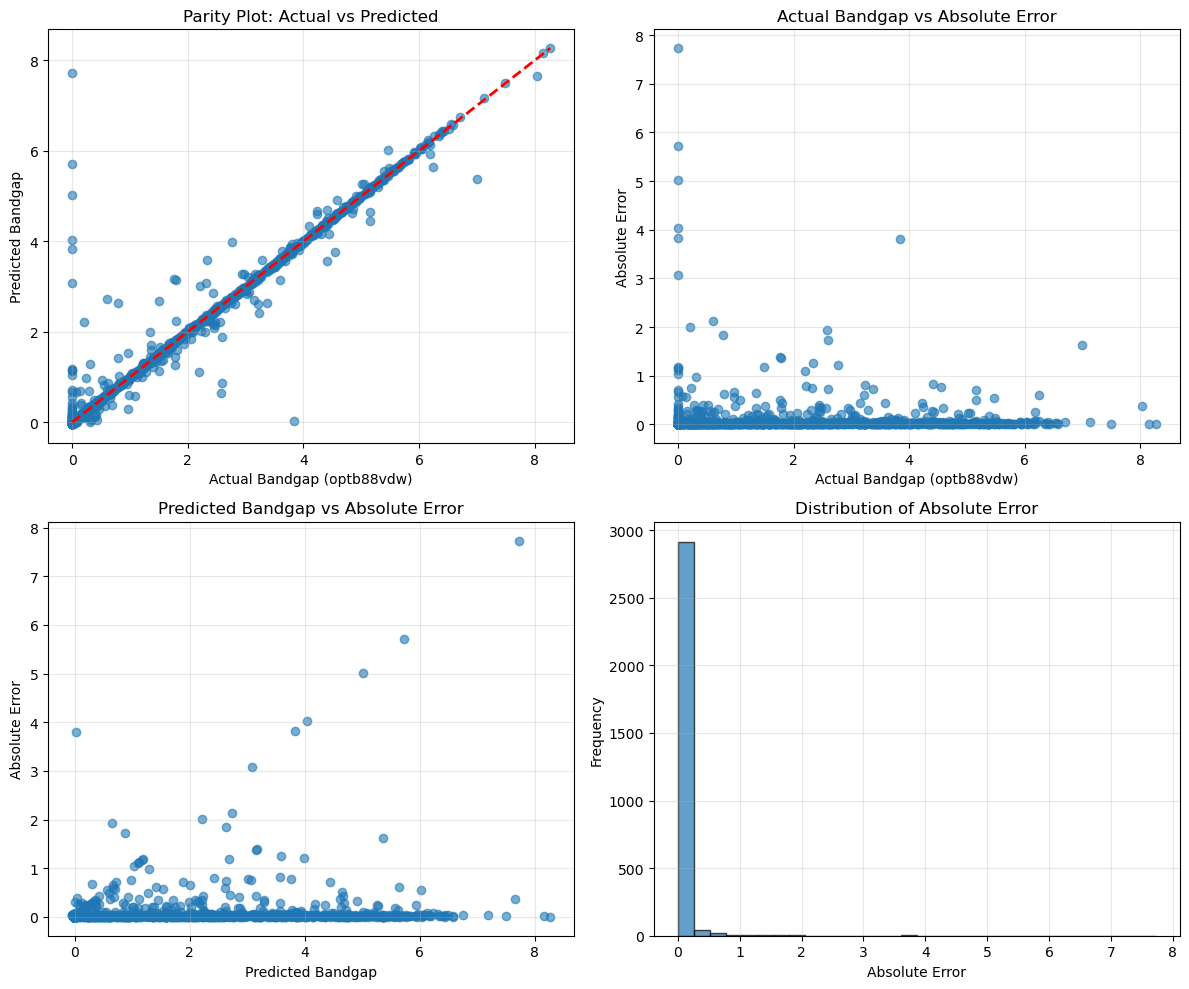

In [6]:
# Create pairwise plots for bandgap analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Extract data for plotting
actual_bandgap = combined_dict['feat_sample_df']['optb88vdw_bandgap']
predicted_bandgap = combined_dict['feat_sample_df']['pred_val']
absolute_error = combined_dict['feat_sample_df']['abs_err']

# Plot 1: Actual vs Predicted (Parity plot)
axes[0, 0].scatter(actual_bandgap, predicted_bandgap, alpha=0.6)
axes[0, 0].plot([actual_bandgap.min(), actual_bandgap.max()], 
                [actual_bandgap.min(), actual_bandgap.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Bandgap (optb88vdw)')
axes[0, 0].set_ylabel('Predicted Bandgap')
axes[0, 0].set_title('Parity Plot: Actual vs Predicted')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Actual vs Absolute Error
axes[0, 1].scatter(actual_bandgap, absolute_error, alpha=0.6)
axes[0, 1].set_xlabel('Actual Bandgap (optb88vdw)')
axes[0, 1].set_ylabel('Absolute Error')
axes[0, 1].set_title('Actual Bandgap vs Absolute Error')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Predicted vs Absolute Error
axes[1, 0].scatter(predicted_bandgap, absolute_error, alpha=0.6)
axes[1, 0].set_xlabel('Predicted Bandgap')
axes[1, 0].set_ylabel('Absolute Error')
axes[1, 0].set_title('Predicted Bandgap vs Absolute Error')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Histogram of Absolute Error
axes[1, 1].hist(absolute_error, bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Absolute Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Absolute Error')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Hessian Eigenvalue Analysis

### Loss Landscape Curvature Characterization
The Hessian eigenvalues provide fundamental insights into the local geometry of the loss landscape around the optimal model parameters. For this analysis:

- **Computation Method**: Eigenvalues computed using 100 samples with lowest prediction error
- **Sample Selection**: 100 samples total (50 with bandgap = 0, 50 with bandgap ≠ 0)
- **Geometric Interpretation**: 
  - Maximum eigenvalue indicates steepest curvature direction
  - Minimum eigenvalue indicates flattest curvature direction
  - Eigenvalue ratios reveal landscape anisotropy

Understanding these curvature properties is essential for interpreting the subsequent loss landscape visualizations and identifying out-of-distribution samples.


In [23]:
# Read and extract eigenvalues from file
eigenvalues_path = r'eigenvectors\JVDFT_bandgap_custom_lowest_250_error_of_3000\eigenvalues.txt'
with open(eigenvalues_path, 'r') as f:
    eigenvalues_data = f.read()
    
print("Eigenvalues data:")
print(eigenvalues_data)

Eigenvalues data:
Maximum eigenvalue: 29.246566772460938
Minimum eigenvalue: 65.32509143354872
Second maximum eigenvalue: 65.32508850097656



## 5. Loss Landscape Visualization

### Average Loss Landscape Analysis
Visualizing the overall loss landscape geometry by computing the logarithmic average of all sample landscapes. This analysis:

- **Methodology**: Logarithmic scaling of mean squared error loss across all 3,000 samples
- **Coordinate System**: Aligned with dominant Hessian eigenvector directions
- **Interpretation**: Shows the typical optimization surface shape for bandgap prediction
- **Axis Labels**: 
  - θ₁: Direction of maximum curvature (Max Hessian Eigenvalue = 65)
  - θ₂: Direction of minimum curvature (Min Hessian Eigenvalue = 29)

The resulting visualization reveals the round, close to isotropic shape of the basin, indicating that the minima is stable.


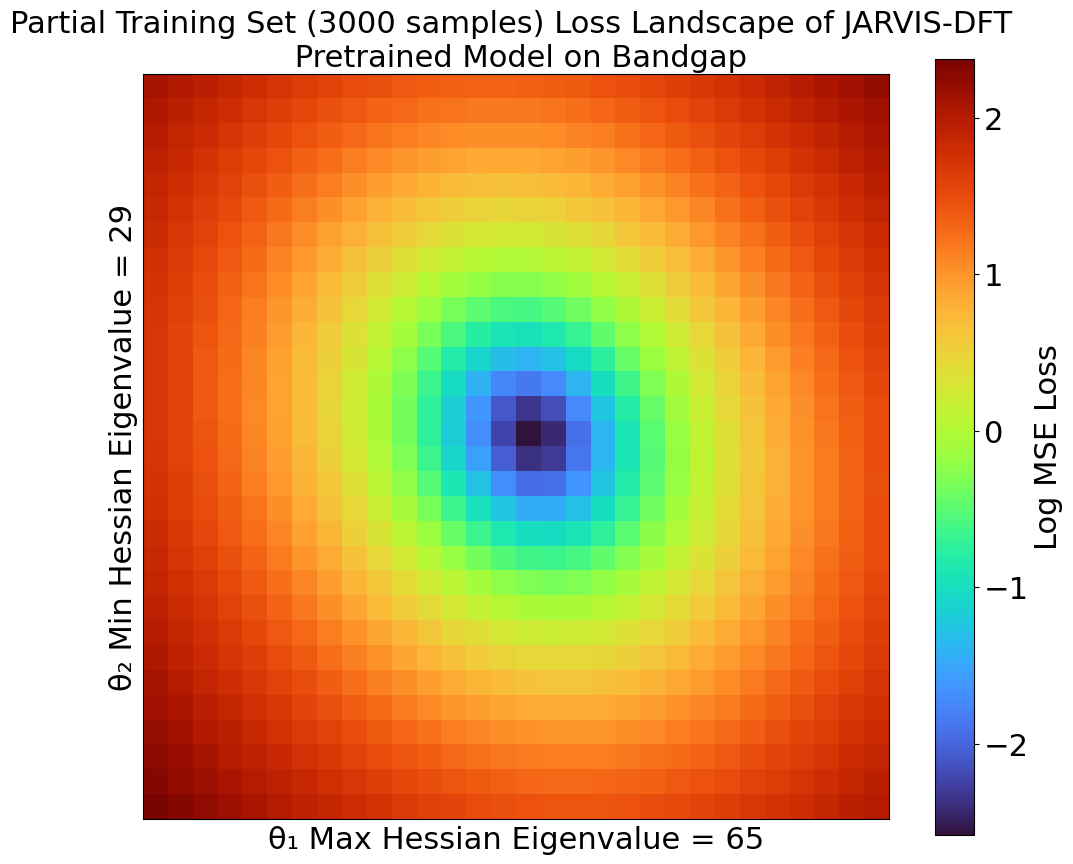

In [ ]:
# Plot average loss landscape for all data
idx = np.where(np.isin(all_data_jids, all_data_jids))[0]
arr = loss_function_dict['first_3000_ON_EIGVEC_JVDFT_bandgap_custom_lowest_250_error_of_3000_mse']['first_3000_ON_EIGVEC_JVDFT_bandgap_custom_lowest_250_error_of_3000_mse_loss_landscape_array'].copy()
avg_landscape = np.log(np.mean(arr[idx], axis=0))

# Remove the last dimension to get a 2D array
array_2d = avg_landscape[:, :, 0]

# Plot the image without interpolation
plt.figure(figsize=(10, 10))
plt.imshow(array_2d, cmap='turbo', origin='lower', extent=(-array_2d.shape[0]/2 -0.5, array_2d.shape[0]/2 -0.5, -array_2d.shape[1]/2 -0.5, array_2d.shape[1]/2 -0.5))
cbar = plt.colorbar(label='Log MSE Loss', shrink=0.8)
cbar.ax.tick_params(labelsize=22)
cbar.set_label('Log MSE Loss', fontsize=22)
plt.title(f'Partial Training Set (3000 samples) Loss Landscape of JARVIS-DFT \n Pretrained Model on Bandgap', fontsize=22)
plt.xlabel('θ₁ Max Hessian Eigenvalue = 65', fontsize=22)
plt.ylabel('θ₂ Min Hessian Eigenvalue = 29', fontsize=22)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()


### Individual Sample Loss Landscape
Examining a specific sample's loss landscape to illustrate individual variations from the average pattern. This visualization demonstrates:

- **Sample-specific geometry**: How individual materials can exhibit unique loss surface shapes
- **Out-of-distribution characteristics**: Landscapes that deviate significantly from the average
- **Local optimization properties**: Sample-specific minima locations and curvature patterns

Such individual analysis is crucial for identifying samples that may be challenging for the model to predict accurately.

Below is an example that is poorly learned by the model.

In [30]:
display(pd.DataFrame(combined_dict['feat_sample_df'].iloc[76]).T)

,jid,spg_number,spg_symbol,formula,formation_energy_peratom,func,optb88vdw_bandgap,atoms,slme,magmom_oszicar,...,coords,elements,abc,angles,cartesian,props,pred_val,err,abs_err,z_score_err
76,JVASP-91520,166,R-3m,LaAlH6,-0.4228,OptB88vdW,2.583,"{'lattice_mat': [[3.2692912795326974, 1.887526...",na,0.0,...,"[[0.0, 5.000000000032756e-06, 3.16254], [0.0, ...","[La, Al, H, H, H, H, H, H]","[4.323911, 4.323911, 4.323908]","[98.2425, 98.2425, 98.2424]",True,"[, , , , , , , ]",0.644565,1.938435,1.938435,6.975429


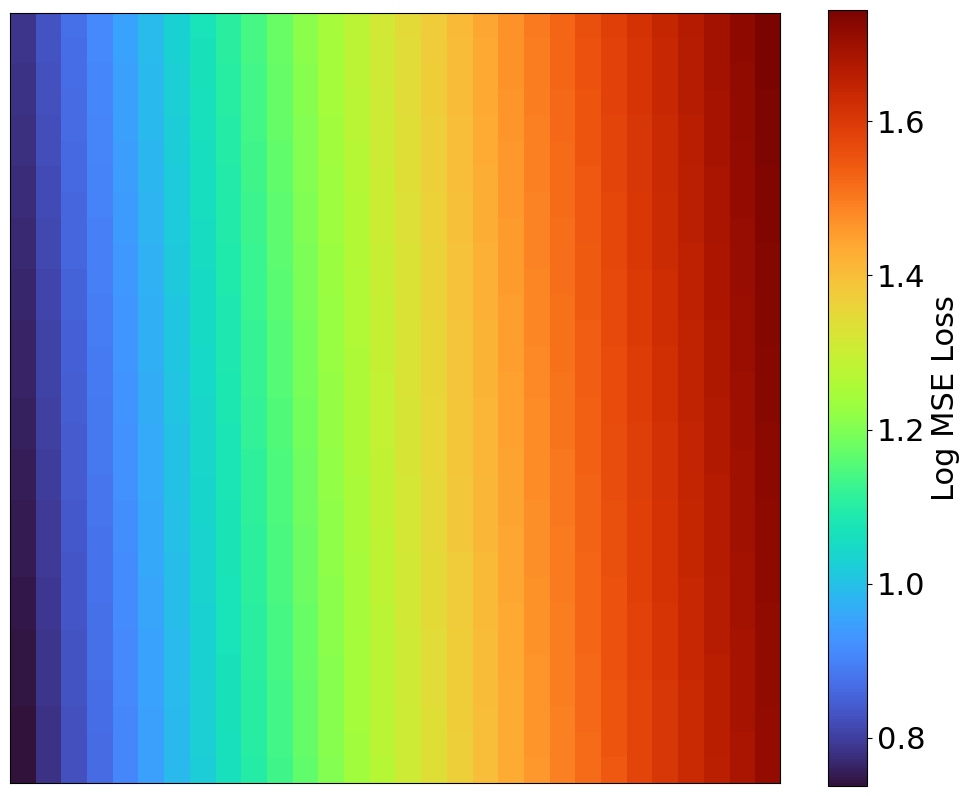

In [31]:
# Load loss landscape data
log_loss_landscape_array = loss_function_dict['first_3000_ON_EIGVEC_JVDFT_bandgap_custom_lowest_250_error_of_3000_mse']['first_3000_ON_EIGVEC_JVDFT_bandgap_custom_lowest_250_error_of_3000_mse_log_loss_landscape_array'].copy()

# Remove the last dimension to get a 2D array
array_2d = log_loss_landscape_array[76][:, :, 0]

# Plot the image without interpolation
plt.figure(figsize=(10, 10))
extent = (-array_2d.shape[0]/2 - 0.5, array_2d.shape[0]/2 - 0.5, 
          -array_2d.shape[1]/2 - 0.5, array_2d.shape[1]/2 - 0.5)
plt.imshow(array_2d, cmap='turbo', origin='lower', extent=extent)

cbar = plt.colorbar(label='Log MSE Loss', shrink=0.8)
cbar.ax.tick_params(labelsize=22)
cbar.set_label('Log MSE Loss', fontsize=22)

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

## 6. Dimensionality Reduction Analysis

### UMAP Visualization of Loss Landscapes
Applying Uniform Manifold Approximation and Projection (UMAP) to analyze the high-dimensional loss landscape data in a lower-dimensional space. This analysis:

- **Methodology**: UMAP transformation of flattened loss landscape arrays
- **Hyperparameters**: n_neighbors=20, min_dist=0.5 for optimal clustering visualization
- **Coloring Schemes**: 
  - Predicted bandgap values to understand prediction-landscape relationships
  - Z-score errors to identify outlier samples and error patterns

This dimensionality reduction enables identification of clusters and patterns that would be impossible to detect in the original high-dimensional space.

Moreover, you could try different coloring schemes such as the matminer features, loss landscape metrics, etc..

In [10]:
# Retrieve the selected loss landscape array using the chosen selectors
log_loss_landscape_array = loss_function_dict['first_3000_ON_EIGVEC_JVDFT_bandgap_custom_lowest_250_error_of_3000_mse']['first_3000_ON_EIGVEC_JVDFT_bandgap_custom_lowest_250_error_of_3000_mse_log_loss_landscape_array'].copy()

# Set UMAP hyperparameters for dimensionality reduction
n_neighbors, min_dist = 20, 0.5

# Initialize UMAP with the specified hyperparameters and a fixed random state for reproducibility
umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)

# Apply UMAP to fit and transform the flattened landscape array data
umap_transformed_data = umap_reducer.fit_transform(flatten_and_vstack(log_loss_landscape_array))

c:\Users\EthanH24\anaconda3\envs\testing_LL_share\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


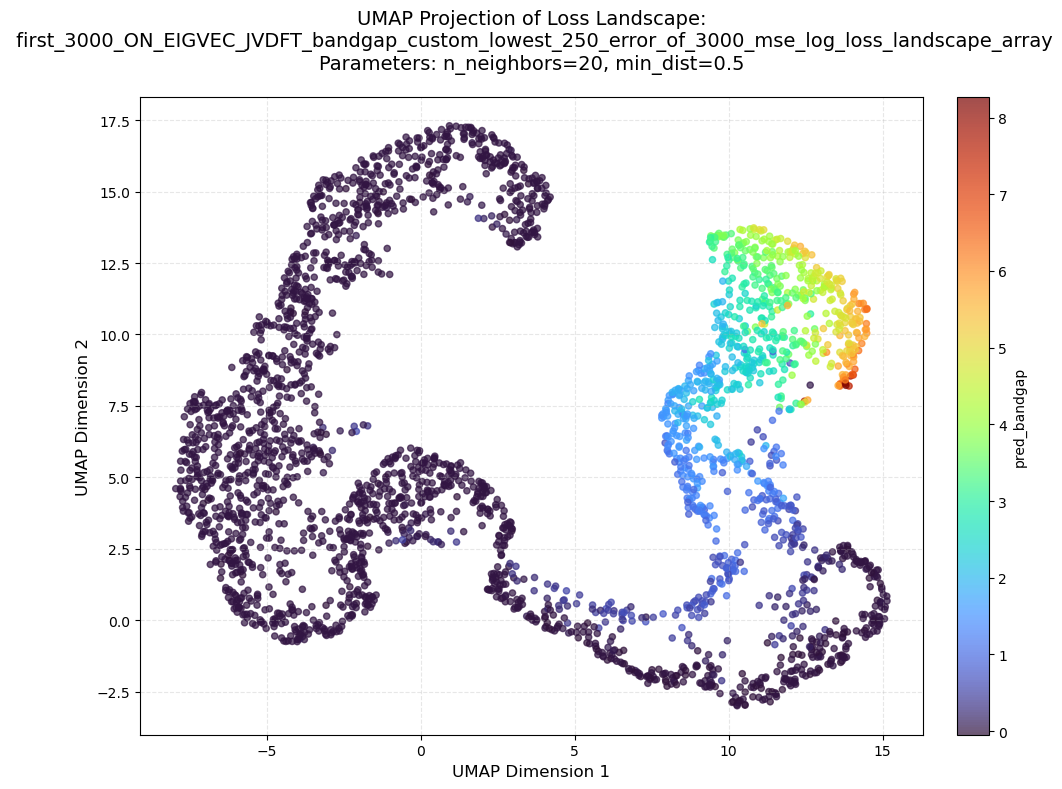

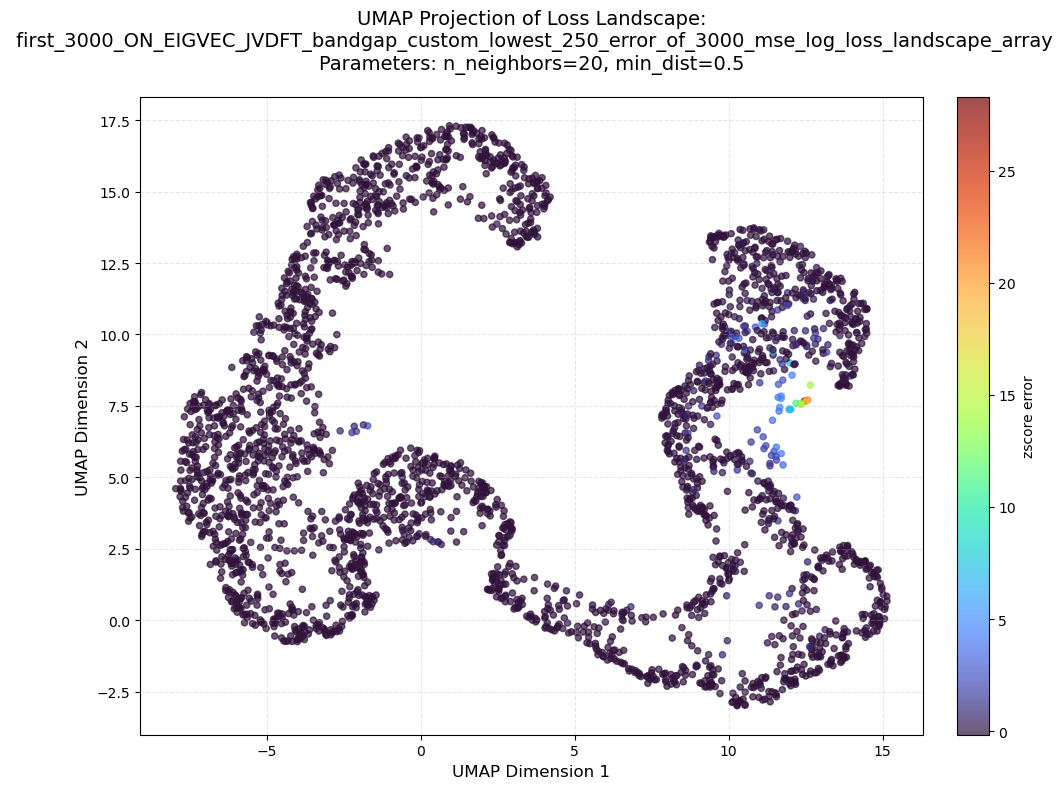

In [11]:
plot_umap_scatter(umap_transformed_data, label_name='pred_bandgap',label_type='continuous',labels=combined_dict['feat_sample_df']['pred_val'].values,n_neighbors=n_neighbors, min_dist=min_dist, landscape_array=log_loss_landscape_array)
plot_umap_scatter(umap_transformed_data, label_name='zscore error',label_type='continuous',labels=combined_dict['feat_sample_df']['z_score_err'].values,n_neighbors=n_neighbors, min_dist=min_dist, landscape_array=log_loss_landscape_array)

## 7. Clustering Analysis

### K-means Clustering on Loss Landscapes
Applying unsupervised clustering to identify distinct groups of materials based on their loss landscape characteristics:

- **Algorithm**: K-means clustering with 8 clusters
- **Input Data**: Flattened loss landscape arrays from all 3,000 samples
- **Visualization**: Cluster assignments overlaid on UMAP projection
- **Interpretation**: Groups materials with similar optimization surface properties

This clustering reveals whether materials with similar loss landscapes share common chemical or structural features, and helps identify potential outliers or unique material classes.

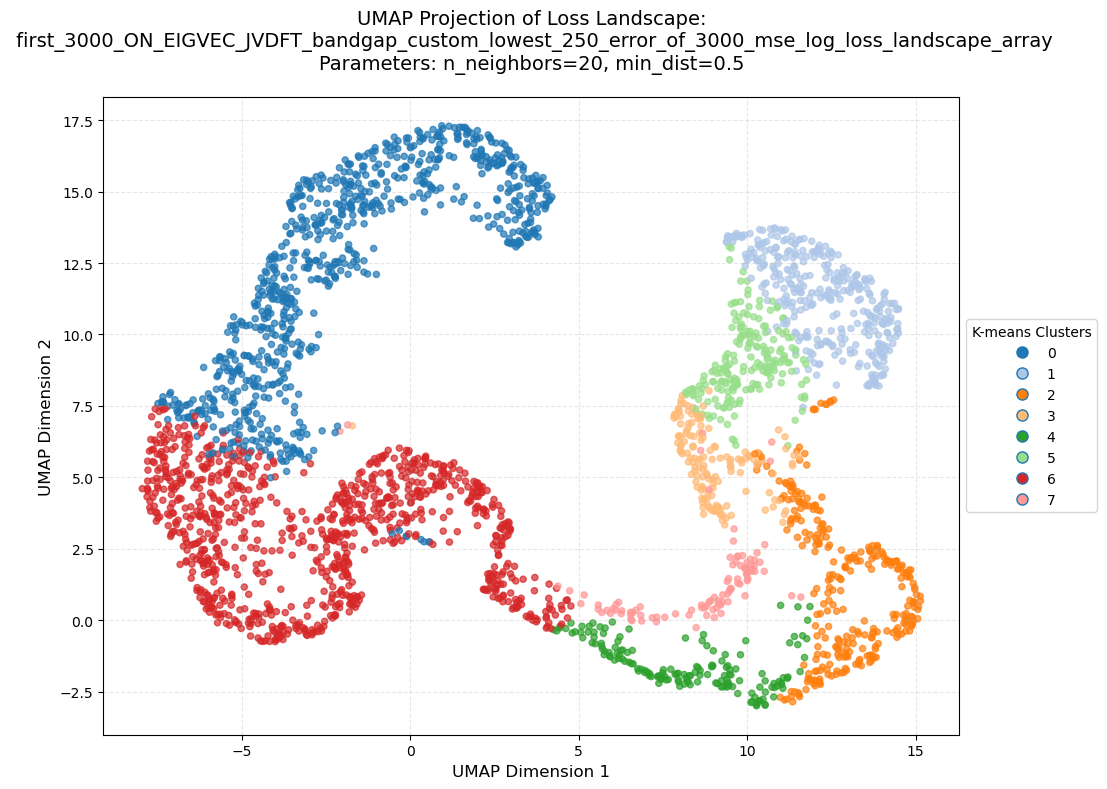

In [12]:
# Initialize and fit K-means clustering with the specified number of clusters
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(flatten_and_vstack(log_loss_landscape_array))
# Retrieve the cluster labels from the fitted K-means model
k_means_labels = kmeans.labels_
plot_umap_scatter(umap_transformed_data, labels=k_means_labels, label_name='K-means Clusters', label_type='categorical', n_neighbors=n_neighbors, min_dist=min_dist, landscape_array=log_loss_landscape_array)

### Cluster-wise Loss Landscape Visualization
Displaying representative loss landscapes from each identified cluster to understand the characteristic patterns within each group:

- **Methodology**: Visualization of up to 30 landscapes per cluster
- **Purpose**: Reveal common geometric features within clusters
- **Interpretation**: Understand what landscape characteristics define each cluster
- **Pattern Recognition**: Identify systematic differences between material groups

This detailed examination helps validate the clustering results and provides insights into the physical or chemical factors that influence loss landscape geometry.

In [14]:
def visualize_image_clusters(arrays, cluster_labels, arrays_per_row=10, max_arrays_per_cluster=None):
    """
    Visualizes clusters of 3D arrays as 2D heatmaps.

    Parameters:
    arrays (list of np.ndarray): A list of 3D numpy arrays, each with shape (n, n, 1).
    cluster_labels (np.ndarray): An array of cluster labels corresponding to each array.
    arrays_per_row (int, optional): Number of arrays to display per row. Defaults to 10.
    max_arrays_per_cluster (int, optional): Maximum number of arrays to display per cluster. 
                                            If None, all arrays in the cluster are displayed.

    Returns:
    None
    """
    unique_labels = np.unique(cluster_labels)
    for label in unique_labels:
        cluster_indices = np.where(cluster_labels == label)[0]
        selected_indices = cluster_indices[:max_arrays_per_cluster]
        cluster_arrays = [arrays[i][:, :, 0] for i in selected_indices]  # Convert 3D arrays to 2D
        
        n_arrays = len(cluster_arrays)
        n_rows = (n_arrays + arrays_per_row - 1) // arrays_per_row
        
        plt.figure(figsize=(arrays_per_row * 1.5, n_rows * 1.5))
        for i, arr in enumerate(cluster_arrays):
                
            plt.subplot(n_rows, arrays_per_row, i + 1)
            plt.imshow(arr, cmap='viridis', origin='lower') 
            plt.axis('off')
        plt.suptitle(f'Cluster {label}', fontsize=16)
        plt.tight_layout()
        plt.show()

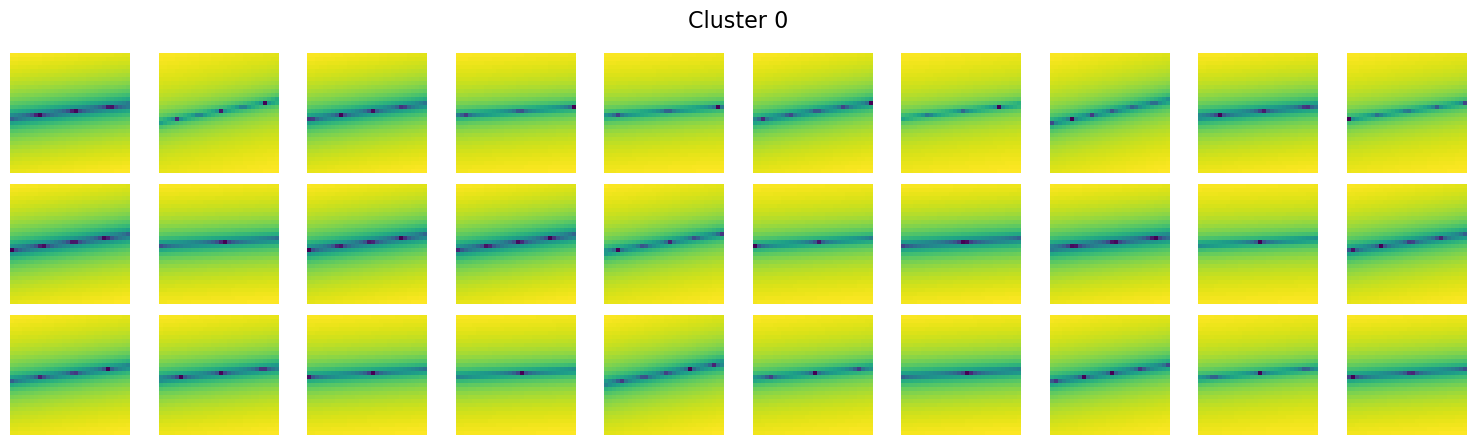

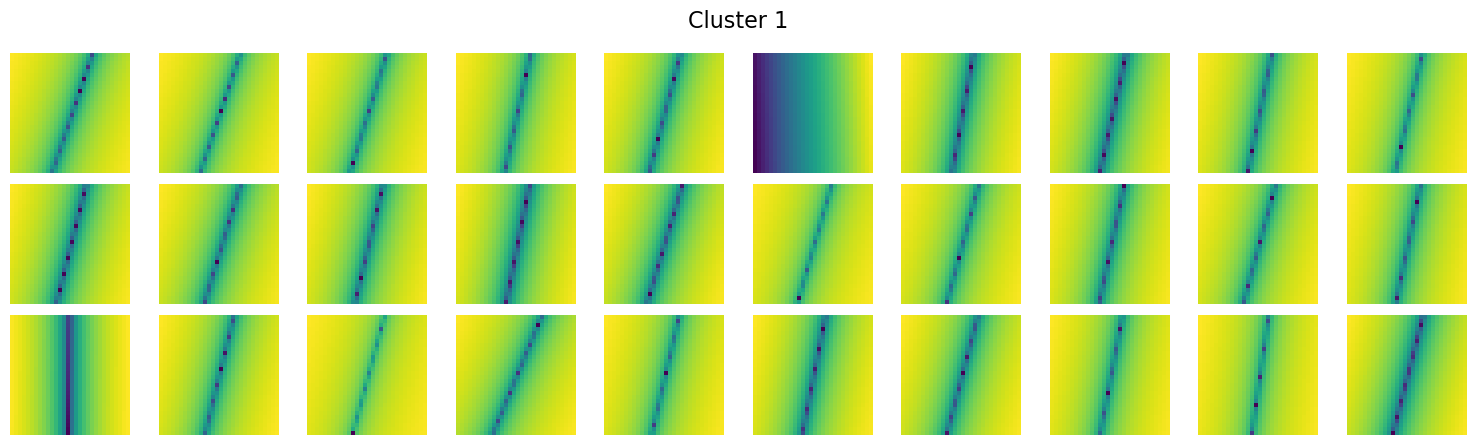

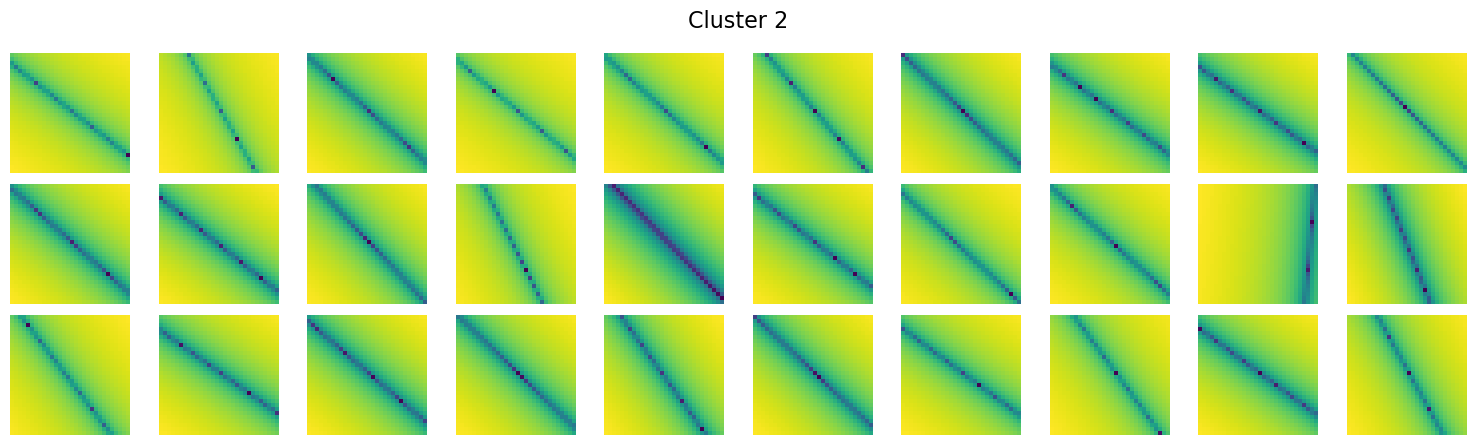

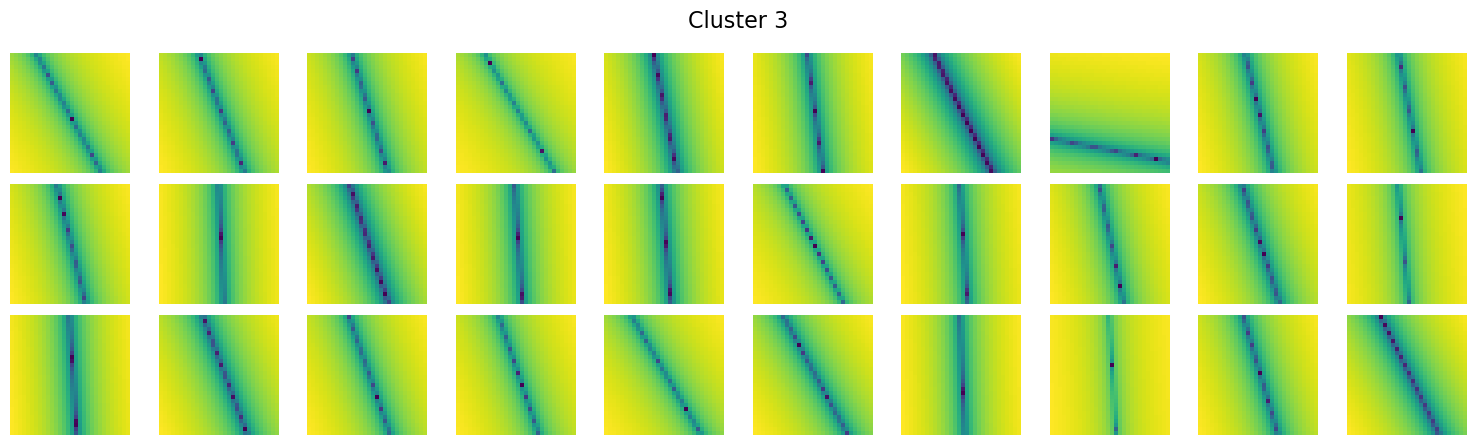

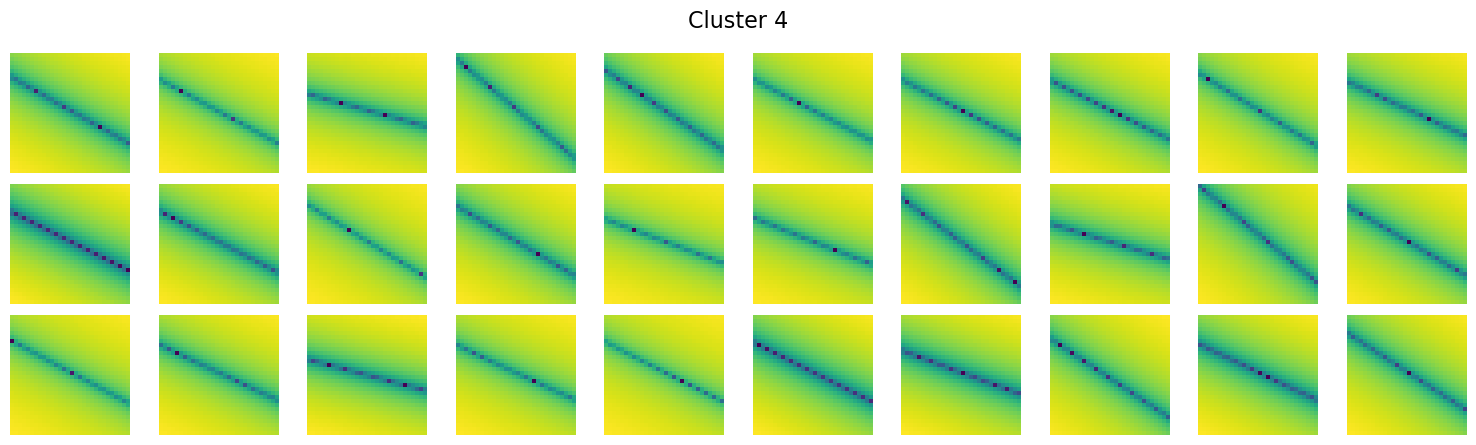

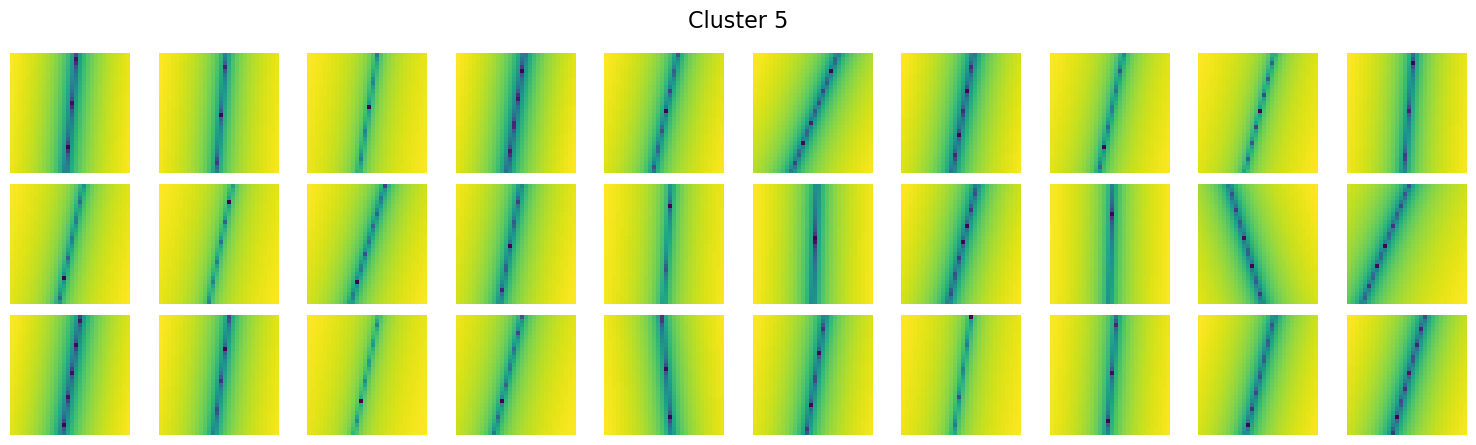

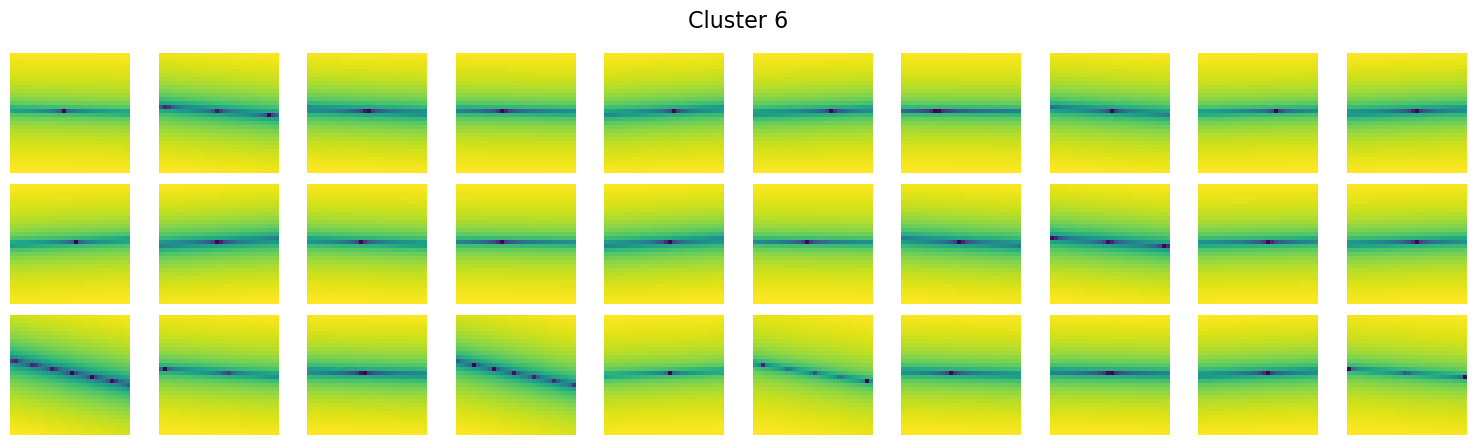

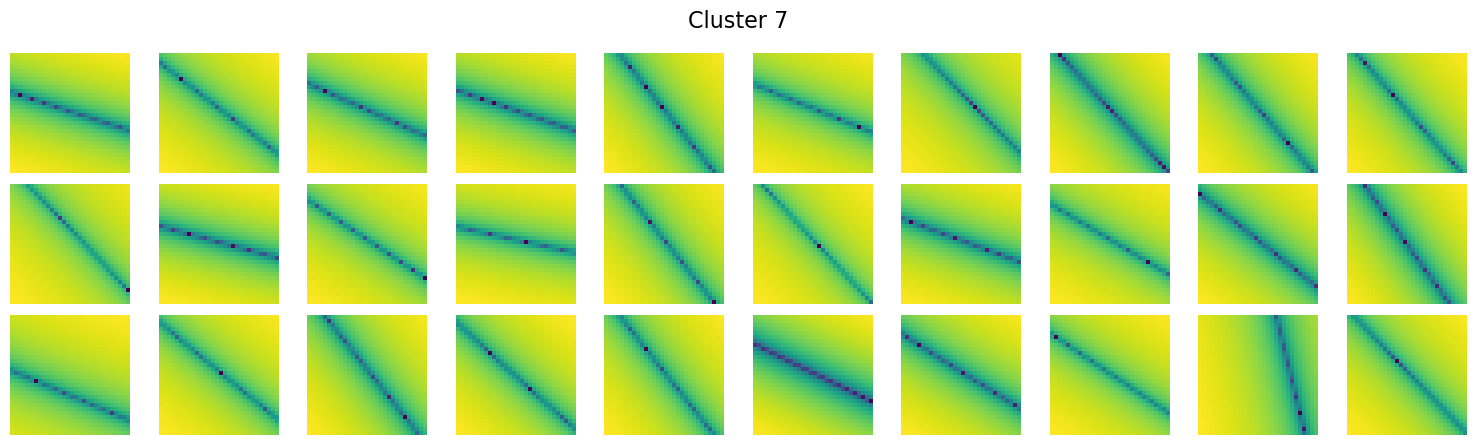

In [15]:
visualize_image_clusters(log_loss_landscape_array, k_means_labels,max_arrays_per_cluster=30)

### Key Observation: Off-Center Loss Landscapes
A significant finding from the cluster analysis is that many loss landscapes do not have their minima centered at the origin. This observation indicates:

- **Out-of-Distribution Samples**: Materials that deviate from the typical optimization behavior
- **Model Limitations**: Samples where the pre-trained model may not generalize well
- **Non-Standard Geometry**: Loss surfaces with displaced minima suggest different optimization characteristics

This pattern is particularly important for identifying samples that may require special attention or alternative modeling approaches. The off-center behavior suggests these materials may be fundamentally different from the training data used to develop the pre-trained model.

## 8. Tilt Angle Analysis

### Quantitative Assessment of Loss Landscape Orientation
Computing tilt angles for each sample's loss landscape:

- **Methodology**: Best-fit tilt angle computation for each loss landscape
- **Angle Modes**: 
  - Signed 90°: Captures directional tilt information with 90° periodicity. 0 is positive y, angle is between [-90 and 90], where angle is positive clockwise.
  - Unsigned 180°: Captures tilt magnitude with 180° periodicity. 0 is positive y, angle is between [0 and 180], where angle is positive clockwise.
- **Correlation Analysis**: Relationship between tilt angles and predicted bandgap values

The tilt angle is interesting because the axes represent the dominant Hessian eigenvector directions, whereas the straight line patterns of the loss landscape hint that the dominant Hessian eigenvectors for each sample could be represented by the linear combination of the Hessian eigenvectors of the aggregate 100 sample subset.

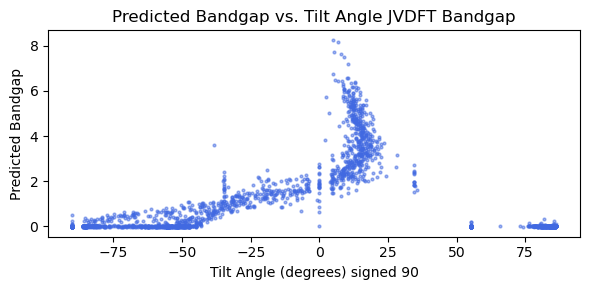

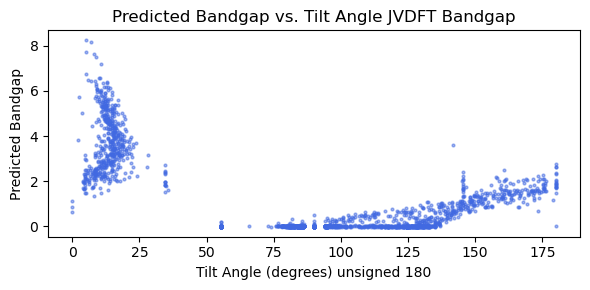

In [18]:
log_loss_landscape_array = loss_function_dict['first_3000_ON_EIGVEC_JVDFT_bandgap_custom_lowest_250_error_of_3000_mse']['first_3000_ON_EIGVEC_JVDFT_bandgap_custom_lowest_250_error_of_3000_mse_log_loss_landscape_array'].copy()

angles_signed90 = []
for i in range(len(log_loss_landscape_array.to_list())):
    angle, _ = compute_best_tilt(log_loss_landscape_array.to_list()[i], degrees=True,angle_mode='signed90', fit_mode=None)
    angles_signed90.append(angle)

angles_unsigned180 = []
for i in range(len(log_loss_landscape_array.to_list())):
    angle, _ = compute_best_tilt(log_loss_landscape_array.to_list()[i], degrees=True,angle_mode='unsigned180', fit_mode=None)
    angles_unsigned180.append(angle)

# #plot histogram of angles
# plt.hist(angles, bins=30, alpha=0.5, color='blue')
# plt.title('Histogram of Tilt Angles')
# plt.xlabel('Tilt Angle (degrees)')
# plt.ylabel('Frequency')
# plt.show()

# Plot predicted values as a function of tilt angle
pred_vals = combined_dict['feat_sample_df']['pred_val']

# Add a vertical line at x=0 and a horizontal line at y=-1 to the previous plot
plt.figure(figsize=(6,3))
plt.scatter(angles_signed90, pred_vals, alpha=0.5, color='royalblue', edgecolor= None, s=4)
plt.xlabel('Tilt Angle (degrees) signed 90')
plt.ylabel('Predicted Bandgap')
plt.title('Predicted Bandgap vs. Tilt Angle JVDFT Bandgap')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.scatter(angles_unsigned180, pred_vals, alpha=0.5, color='royalblue', edgecolor= None, s=4)
plt.xlabel('Tilt Angle (degrees) unsigned 180')
plt.ylabel('Predicted Bandgap')
plt.title('Predicted Bandgap vs. Tilt Angle JVDFT Bandgap')
plt.tight_layout()
plt.show()
